In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss, roc_auc_score

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchfm.model.ffm import FieldAwareFactorizationMachineModel

from tqdm.auto import trange, tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants

In [34]:
DATA_PATH = '/kaggle/input/ad-clicks/data.csv'

BATCH_SIZE = 32

In [35]:
def read_data(data_path) -> pd.DataFrame: 
    data = pd.read_csv(data_path, parse_dates=['date_time'])

    # will be used in next HWs
    cols_for_other_hws = ['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1']

    # has only one value for all rows
    cols_constant = ['impressions']

    data = data[data.date_time > '2021-09-26'] # delete outlier
    data.drop(cols_for_other_hws, axis=1, inplace=True)
    data.drop(cols_constant, axis=1, inplace=True)
    data.dropna(inplace=True)

    return data

data = read_data(DATA_PATH)
data.head()

date_time  zone_id  banner_id            oaid_hash  \
0 2021-09-27 00:01:30        0          0  5664530014561852622   
1 2021-09-26 22:54:49        1          1  5186611064559013950   
2 2021-09-26 23:57:20        2          2  2215519569292448030   
3 2021-09-27 00:04:30        3          3  6262169206735077204   
4 2021-09-27 00:06:21        4          4  4778985830203613115   

   campaign_clicks  os_id  country_id  clicks  
0                0      0           0       1  
1                0      0           1       1  
2                3      0           0       1  
3                0      1           1       1  
4                0      1           0       1

# Analysis

### Посмотрим распределение **по дням**

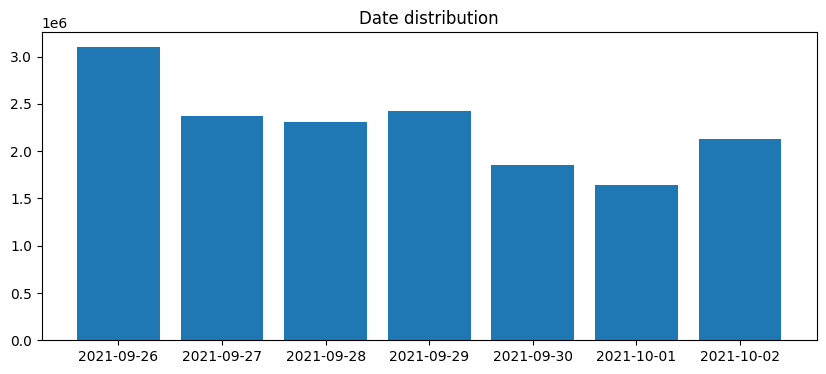

In [36]:
date_counts = data['date_time'].groupby(data['date_time'].dt.date).count()
date_names = date_counts.index.values
y = date_counts.values
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('Date distribution')
plt.bar(bins, height=y)
plt.xticks(bins, date_names)
plt.show()

### Посмотрим распределение **по часам**

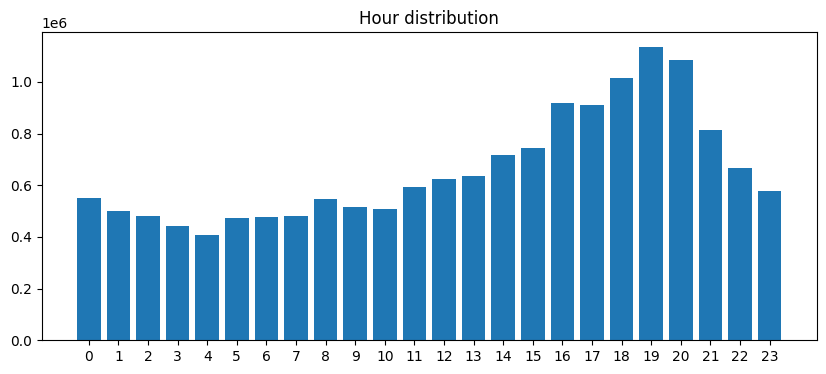

In [37]:
hour_counts = data['date_time'].groupby(data['date_time'].dt.hour).count()
hour_names = hour_counts.index.values
y = hour_counts.values
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('Hour distribution')
plt.bar(bins, height=y)
plt.xticks(bins, hour_names)
plt.show()

### Посмотрим на распределение единственной числовой фичи

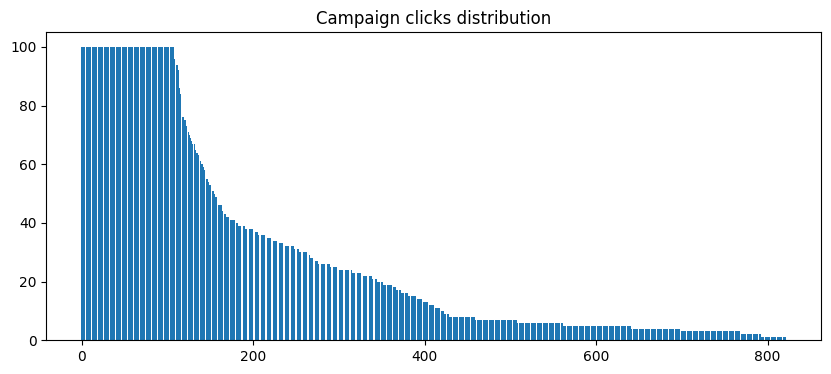

In [38]:
y = data['campaign_clicks'].value_counts().values.copy()
y = y.clip(0, 100)
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('Campaign clicks distribution')
plt.bar(bins, height=y)
plt.show()

### Распределение очень сильно скошено к 0, поэтому стоит использовать логарифм этой фичи

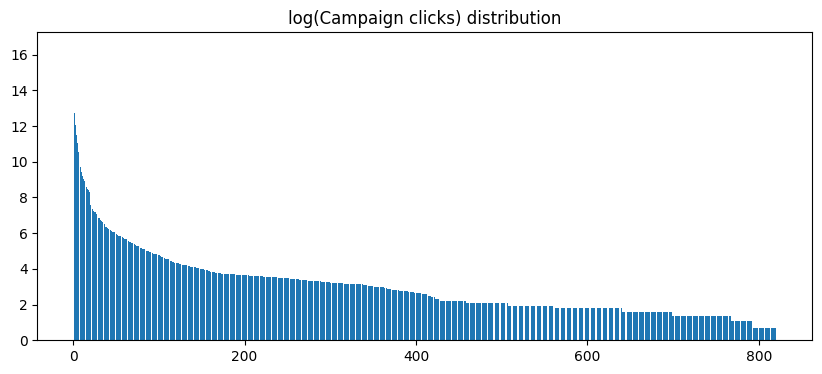

In [39]:
y = data['campaign_clicks'].value_counts().values.copy()
y = np.log(y + 1)
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('log(Campaign clicks) distribution')
plt.bar(bins, height=y)
plt.show()

### Действительно, стоило бы отонситься к этой фиче как к числовой, но используемая модель принимает на вход тензор с индексами, поэтому будем относиться как к категориальной

### Дополнительно объединим категории со значением больше 100

In [40]:
print('Unique values:')
print(data.nunique())

Unique values:
date_time           604710
zone_id               3444
banner_id             1633
oaid_hash          6510305
campaign_clicks        822
os_id                   11
country_id              17
clicks                   2
dtype: int64


### Доля пользователей, для которых всего k наблюдений в датасете:

In [41]:
data.oaid_hash.value_counts().value_counts(normalize=True)[:10]

count
1     0.642490
2     0.161148
3     0.066383
4     0.035818
5     0.022195
6     0.014689
7     0.010231
8     0.007686
9     0.005877
10    0.004632
Name: proportion, dtype: float64

### Слишком ресурсоёмко строить эмбеддинги для каждого пользователя, поэтому будем строить только для тех, кто имеет 6 и более наблюдений

# Feature Engineering

In [46]:
def feature_engineering(data: pd.DataFrame):
    data = data.copy()
    # campaign_clicks
    data.loc[:, 'campaign_clicks'] = data['campaign_clicks'].apply(lambda x: min(int(x), 100))

    # add day_of_week and hour features
    data['day'] = data['date_time'].dt.day_of_week
    data['hour'] = data['date_time'].dt.hour

    # add interactions
    data['banner_id/os_id'] = data['banner_id'].astype(str) + '/' + data['os_id'].astype(str)
    data['banner_id/zone_id'] = data['banner_id'].astype(str) + '/' + data['zone_id'].astype(str)

    # group users who have 10 or less observations
    data['obs_count'] = data.groupby('oaid_hash').transform('size')
    data.loc[data['obs_count'] <= 10, 'oaid_hash'] = 0
    data.drop(['obs_count'], axis=1, inplace=True)

    return data

engineered_data = feature_engineering(data)

print('Unique values:')
print(engineered_data.nunique())

Unique values:
date_time            604710
zone_id                3444
banner_id              1633
oaid_hash            187835
campaign_clicks         101
os_id                    11
country_id               17
clicks                    2
day                       7
hour                     24
banner_id/os_id        3689
banner_id/zone_id    195979
dtype: int64


In [47]:
engineered_data[['banner_id/os_id', 'banner_id/zone_id']].head()

banner_id/os_id banner_id/zone_id
0             0/0               0/0
1             1/0               1/1
2             2/0               2/2
3             3/1               3/3
4             4/1               4/4

# Prepare data

In [48]:
class Mapper:
    def __init__(self):
        self.mapper = dict()
        self.unknown_idx = 0
        self.curr_idx = 1

    def fit(self, arr):
        for elem in arr:
            if elem not in self.mapper:
                self.mapper[elem] = self.curr_idx
                self.curr_idx += 1

    def transform(self, arr):
        return np.array([self.mapper[elem] if elem in self.mapper else self.unknown_idx for elem in arr])

    def fit_transform(self, arr):
        self.fit(arr)
        return self.transform(arr)


def prepare_data(data):
    # getting train-val-test indices
    last_day = data.date_time.max().date()
    last_but_one_day = last_day - pd.Timedelta(days=1)

    train_index = data[data.date_time.dt.date < last_but_one_day].index
    val_index = data[data.date_time.dt.date == last_but_one_day].index
    test_index = data[data.date_time.dt.date == last_day].index

    # drop date_time column
    data = data.drop(['date_time'], axis=1)

    # get field dimensions
    field_dims = data.drop(['clicks'], axis=1).nunique().values

    # train-val-test split
    train_data = data.loc[train_index]
    val_data = data.loc[val_index]
    test_data = data.loc[test_index]

    # vectorize features
    mapper_banner_os = Mapper()
    train_data['banner_id/os_id'] = mapper_banner_os.fit_transform(train_data['banner_id/os_id'].values)
    val_data['banner_id/os_id'] = mapper_banner_os.transform(val_data['banner_id/os_id'].values)
    test_data['banner_id/os_id'] = mapper_banner_os.transform(test_data['banner_id/os_id'].values)

    mapper_banner_zone = Mapper()
    train_data['banner_id/zone_id'] = mapper_banner_zone.fit_transform(train_data['banner_id/zone_id'].values)
    val_data['banner_id/zone_id'] = mapper_banner_zone.transform(val_data['banner_id/zone_id'].values)
    test_data['banner_id/zone_id'] = mapper_banner_zone.transform(test_data['banner_id/zone_id'].values)

    mapper_oaid_hash = Mapper()
    train_data['oaid_hash'] = mapper_oaid_hash.fit_transform(train_data['oaid_hash'].values)
    val_data['oaid_hash'] = mapper_oaid_hash.transform(val_data['oaid_hash'].values)
    test_data['oaid_hash'] = mapper_oaid_hash.transform(test_data['oaid_hash'].values)

    # features
    X_train = torch.tensor(train_data.drop(['clicks'], axis=1).values)
    X_val = torch.tensor(val_data.drop(['clicks'], axis=1).values)
    X_test = torch.tensor(test_data.drop(['clicks'], axis=1).values)

    # target
    y_train = torch.tensor(train_data['clicks'].values)
    y_val = torch.tensor(val_data['clicks'].values)
    y_test = torch.tensor(test_data['clicks'].values)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), field_dims, mapper_banner_os, mapper_banner_zone


(X_train, y_train), (X_val, y_val), (X_test, y_test), field_dims, _, _ = prepare_data(engineered_data)

print(f'features:        {X_train.shape[1]}\n')

print(f'train size:      {len(y_train)}')
print(f'validation size: {len(y_val)}')
print(f'test size:       {len(y_test)}\n')

print(f'field dims: {field_dims.tolist()}')

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

features:        10

train size:      12049017
validation size: 1643448
test size:       2128978

field dims: [3444, 1633, 187835, 101, 11, 17, 7, 24, 3689, 195979]


# Hyperparams selection

Здесь должен был находиться перебор размерности эмбеддингов, но обучение занимает слишком много времени

# Train

In [49]:
embed_dim = 5
np.long = np.float64
model = FieldAwareFactorizationMachineModel(field_dims, embed_dim).to(device)

def train(model, epochs, train_loader, optimizer, criterion):
    model.train()

    for _ in trange(epochs):
        for X_batch, y_batch in tqdm(train_loader):                                  
            X_batch = X_batch.to(device).long()            
            y_batch = y_batch.to(device).float()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

train(
    model=model,
    epochs=1,
    train_loader=train_loader,
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001),
    criterion=torch.nn.BCELoss()
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/376532 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Perfomance

In [51]:
def test(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader):                                  
            X_batch = X_batch.to(device).long()  
            y_true.extend(y_batch.tolist())                                  
            y_pred.extend(model(X_batch).detach().cpu().tolist())                        

    log_loss_result = log_loss(y_true, y_pred)
    roc_auc_result = roc_auc_score(y_true, y_pred)

    return log_loss_result, roc_auc_result

log_loss_result, roc_auc_result = test(model, test_loader)

print(f'log loss: {log_loss_result}')
print(f'roc_auc_score: {roc_auc_result}')

  0%|          | 0/66531 [00:00<?, ?it/s]

log loss: 0.6749242835828715
roc_auc_score: 0.5463207133154748


### Результаты в предыдущей работе:
log loss: 0.13359587610199455

roc_auc_score: 0.779136370914316

Получен более низкий результат, чем в прошлой работе. Полагаю, дело в том что:
1. одной эпохи недостаточно,
2. маловат размер эмбеддингов (5),
3. уникальные эмбеддинги  имеют только пользователи, для которых в датасете есть 11 и более наблюдений (в целях сокращения времени обучения)